In [ ]:
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_colwidth", 50)
pd.set_option("display.width", 120)

In [2]:
data_dir_proc = 'data/processed'
expression = pd.read_csv(Path(data_dir_proc) / 'expression.tsv', sep='\t', index_col=0)

# inspect

In [3]:
# check for missing values
n_missing = expression.isna().sum()
assert (n_missing == 0).all()

In [4]:
# check expression dtypes
expression.dtypes.value_counts()

float64    20530
Name: count, dtype: int64

Text(0.5, 0, '')

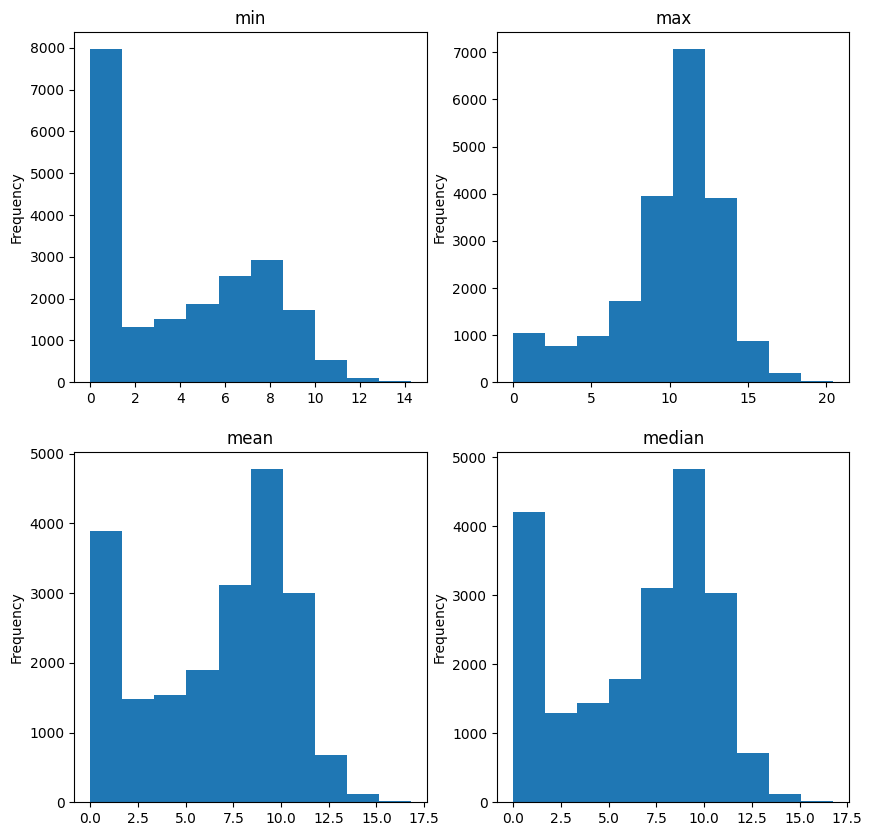

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

expression.min().plot(kind='hist', ax=axes[0,0], subplots=True)
axes[0, 0].set_title('min')
axes[0, 0].set_xlabel('')

expression.max().plot(kind='hist', ax=axes[0,1], subplots=True)
axes[0, 1].set_title('max')
axes[0, 1].set_xlabel('')

expression.mean().plot(kind='hist', ax=axes[1,0], subplots=True)
axes[1, 0].set_title('mean')
axes[1, 0].set_xlabel('')

expression.median().plot(kind='hist', ax=axes[1,1], subplots=True)
axes[1, 1].set_title('median')
axes[1, 1].set_xlabel('')

# spike of low min values (zeros)
# the mean and median look quite similar

# variances

In [16]:
variances = expression.var()

In [17]:
variances.describe()

count    20530.000000
mean         1.250980
std          1.725229
min          0.000000
25%          0.291872
50%          0.616751
75%          1.551435
max         29.236850
dtype: float64

In [18]:
print(f'{(variances == 0).sum()} genes with zero variance')

338 genes with zero variance


In [19]:
variances[variances > 0].describe()

count    20192.000000
mean         1.271920
std          1.731937
min          0.000165
25%          0.301846
50%          0.635349
75%          1.578235
max         29.236850
dtype: float64

<Axes: ylabel='Frequency'>

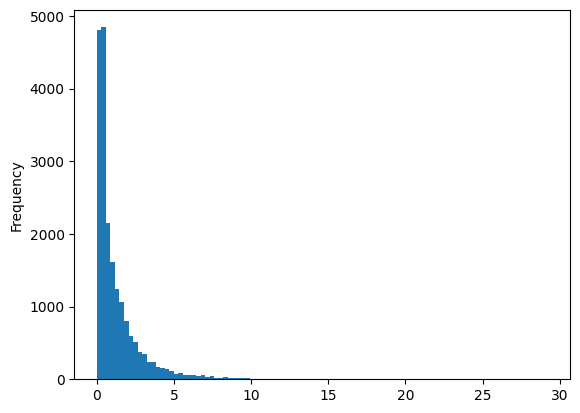

In [20]:
variances[variances > 0].plot(kind='hist', bins=100)

In [21]:
varthresholds = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
df = pd.DataFrame([(variances < v).sum() for v in varthresholds], columns=['n'], index=varthresholds)
df['p'] = df['n'] / len(variances)
df

,n,p
1.000000e-08,338,0.016464
1.000000e-07,338,0.016464
1.000000e-06,338,0.016464
1.000000e-05,338,0.016464
1.000000e-04,338,0.016464
1.000000e-03,401,0.019532
1.000000e-02,685,0.033366
1.000000e-01,1355,0.066001
1.000000e+00,12874,0.627082


# PCA

In [ ]:
X = expression
X.shape # initial dimensions

(506, 20530)

In [ ]:
varthresh = VarianceThreshold(threshold=1e-5)
X_varthresh = varthresh.fit_transform(X)
X_varthresh.shape

(506, 20192)

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_varthresh)
X_scaled.shape

(506, 20192)

In [27]:
pca = PCA(n_components=X_scaled.shape[0], svd_solver='randomized')
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(506, 506)

In [ ]:
W = pca.components_  # get pca loadings
W.shape

(506, 20192)

In [29]:
pd.DataFrame(W).head()

,0,1,2,3,4,...,20187,20188,20189,20190,20191
0,-0.008438,-0.006145,-0.001270,0.000248,0.000431,...,-0.011921,-0.009619,0.000895,-0.014770,0.009496
1,-0.006070,-0.002351,-0.000175,-0.001868,0.005801,...,0.004846,0.004259,-0.010983,0.000276,-0.004204
2,-0.002305,-0.007435,-0.000876,-0.010574,0.014687,...,0.008581,0.003003,0.011794,0.007513,0.005553
3,0.013566,-0.005012,0.002765,-0.002071,-0.005509,...,0.011578,0.006328,0.008511,-0.002547,-0.003714
4,0.005245,-0.009171,-0.003171,0.005237,-0.003026,...,0.012269,0.003851,0.003839,-0.004533,-0.007425


Text(0, 0.5, 'pca2')

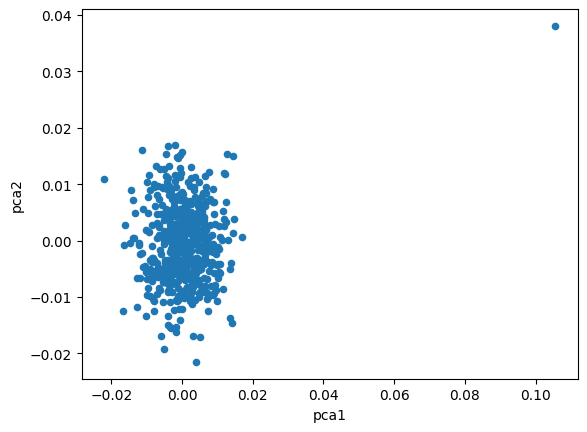

In [30]:
ax = pd.DataFrame(W).plot(kind='scatter', x=0, y=1)
ax.set_xlabel('pca1')
ax.set_ylabel('pca2')

In [ ]:
# cumulative variance explained by principal components
cum_var_exp = pd.Series(pca.explained_variance_ratio_).cumsum()
cum_var_exp.index = cum_var_exp.index + 1
cum_var_exp

1      0.080313
2      0.141343
3      0.196274
4      0.241445
5      0.274795
         ...   
502    0.999225
503    0.999491
504    0.999747
505    1.000000
506    1.000000
Length: 506, dtype: float64

In [ ]:
# check cumulative variance explained for a selection of num components
cum_var_exp.loc[np.linspace(50, 500, 10)]

50     0.599189
100    0.712702
150    0.783230
200    0.835165
250    0.876255
300    0.910071
350    0.938381
400    0.962330
450    0.982398
500    0.998676
dtype: float64

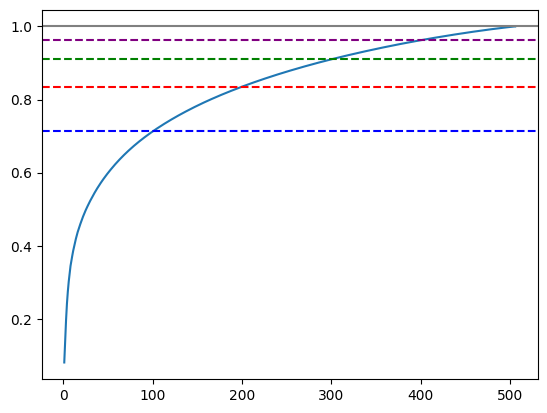

In [ ]:
ax = cum_var_exp.plot()
ax.axhline(1, color="grey")
ax.axhline(cum_var_exp.loc[100], color="blue", linestyle="--")
ax.axhline(cum_var_exp.loc[200], color="red", linestyle="--")
ax.axhline(cum_var_exp.loc[300], color="green", linestyle="--")
ax.axhline(cum_var_exp.loc[400], color="purple", linestyle="--")

# 100 components explain ~71%
# 200 components explain ~83%
# 300 components explain ~91%
# 400 components explain ~96%
